In [1]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

from tensorflow.keras.layers import Layer, Lambda, Conv2D, Dropout,Dense,Activation,Input,GlobalAveragePooling1D, Concatenate, GlobalAveragePooling2D, LayerNormalization, MaxPool2D
from tensorflow.keras.layers import Reshape,Flatten,BatchNormalization,MaxPooling1D,AveragePooling2D,Reshape,Attention, ReLU, Activation, SpatialDropout2D, DepthwiseConv2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold
import keras.backend as K
from tensorflow.keras.optimizers import Adam
from tqdm.auto import tqdm
import os
from Config import Config
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Mean, CategoricalAccuracy
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from datetime import datetime
import random
import matplotlib.pyplot as plt
from tensorflow.keras.losses import CategoricalCrossentropy, MeanSquaredError

import tensorflow as tf
tf.config.run_functions_eagerly(True)

import warnings
warnings.filterwarnings('always')

from utils import *

In [2]:
seed_everything(42)

In [3]:
DATA_ROOT = 'TIMNET-dataset'
DATA_PATH = 'RAVDESS'
CLASS_LABELS = Config.RAVDESS_LABELS
k = 10

# 캡슐로 바꾸는 부분 Depthwise-separable CNN
# Banila CNN + dialted CNN
# CBAM
model_name = 'RoutingConvNet(64 CNN, Last dilated)+CBAM+Depthwise-separable(Caps)'
feature_name = 'mfcc'

learning_rate=0.001
beta_1=0.975
beta_2=0.932
epsilon=1e-8

EPOCHS = 300
BATCH = 32

In [4]:
def PrimaryCapssquash(vectors, axis=-1):
    """
        The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
        :param vectors: some vectors to be squashed, N-dim tensor
        :param axis: the axis to squash
        :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors

In [5]:
class PrimaryCap(tf.keras.Model):

  def __init__(self, dim_capsule=64, n_channels=6, kernel_size=3, strides=1, padding='valid'):
    super().__init__()
    
    self.conv = Sequential([
        # depthwise-separable Conv2D
        DepthwiseConv2D(kernel_size=kernel_size, strides=strides, padding=padding),
        Conv2D(filters=dim_capsule*n_channels, kernel_size=1),
        
        Reshape(target_shape=[-1, dim_capsule], name='primarycap_reshape'),
        Lambda(function=PrimaryCapssquash, name='primarycap_squash')
    ])
    
  def call(self, inputs):
    x = self.conv(inputs)
    return x

In [6]:
def DigitCapssquash(Value, axis = -1):
    """
        Squash activation in PrimaryCaps
        :return: a Tensor with same shape as input vectors
    """
    Square_Vector = K.sum(K.square(Value), axis, keepdims=True)
    Proportion = Square_Vector / (1 + Square_Vector) / K.sqrt(Square_Vector + K.epsilon())
    Output = Proportion * Value
    return Output

In [7]:
def softmax(x, axis=-1):
    """
        softmax in Dynamic Routings
    """ 
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex/K.sum(ex, axis=axis, keepdims=True)

In [8]:
class Capsule(tf.keras.layers.Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, share_weights=True, activation='squash', **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        self.activation = DigitCapssquash
        
    def get_config(self):
       config = {"num_capsule":self.num_capsule,
                 "dim_capsule":self.dim_capsule,
                 "routings":self.routings,
                 "share_weights":self.share_weights,
                 "activation":self.activation
                }
       base_config = super(Capsule, self).get_config()
       return dict(list(base_config.items()) + list(config.items()))
    
    def build(self, input_shape):
        super(Capsule, self).build(input_shape)
        input_dim_capsule = input_shape[-1]
        #input_dim_capsule = 8
        if self.share_weights:
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(1, input_dim_capsule,#input_dim_capsule = 16
                                            self.num_capsule * self.dim_capsule), #16*32
                                     initializer='glorot_uniform',
                                     trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(input_num_capsule,
                                            input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)
    
    def call(self, u_vecs):
        if self.share_weights:
            u_hat_vecs = K.conv1d(u_vecs, self.W)
        else:
            u_hat_vecs = K.local_conv1d(u_vecs, self.W, [1], [1])

        batch_size = K.shape(u_vecs)[0]
        input_num_capsule = K.shape(u_vecs)[1]
        u_hat_vecs = K.reshape(u_hat_vecs, (batch_size, input_num_capsule,
                                            self.num_capsule, self.dim_capsule))
        u_hat_vecs = K.permute_dimensions(u_hat_vecs, (0, 2, 1, 3))

        b = K.zeros_like(u_hat_vecs[:,:,:,0])

        for i in range(self.routings): #Routings
            c = softmax(b, 1)

            o = tf.einsum('bin,binj->bij', c, u_hat_vecs)
            if K.backend() == 'theano':
                o = K.sum(o, axis=1)
            if i < self.routings - 1:
                o = K.l2_normalize(o, -1)
                b = tf.einsum('bij,binj->bin', o, u_hat_vecs)
                if K.backend() == 'theano':
                    b = K.sum(b, axis=1)

        return self.activation(o)

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

In [9]:
class SpatialGate(tf.keras.Model):
  def __init__(self):
    super(SpatialGate, self).__init__()
    kernel_size = 7
    self.spatial = Conv2D(filters=1, kernel_size=kernel_size, strides=1, padding='same', use_bias=False)
    self.bn = BatchNormalization(momentum=0.01, epsilon=1e-5)
    self.relu = Activation('relu')
    
  def call(self, x):
     avg_pool = tf.reduce_mean(x, axis=[3], keepdims=True)
     max_pool = tf.reduce_max(x, axis=[3], keepdims=True)
     x_compress = tf.concat([avg_pool,max_pool], 3)
     
     x_out = self.spatial(x_compress)
     x_out = self.bn(x_out)
     x_out = self.relu(x_out)
     
     scale = tf.math.sigmoid(x_out) # broadcasting
     return x * scale

In [10]:
class ChannelGate(tf.keras.Model):

  def __init__(self, gate_channels):
    super(ChannelGate, self).__init__()
    self.gate_channels = gate_channels
    self.mlp = Sequential([
        Flatten(),
        Dense(gate_channels // 2, activation='relu'),
        Dense(gate_channels, activation=None)
    ])
  def call(self, x):
    channel_att_sum = None
    
    avg_pool_layer = AveragePooling2D(pool_size=(x.shape[1], x.shape[2]), strides=(x.shape[1], x.shape[2]))
    avg_pool = avg_pool_layer(x)
    avg_pool_raw = self.mlp(avg_pool)
    max_pool_layer = MaxPool2D(pool_size=(x.shape[1], x.shape[2]), strides=(x.shape[1], x.shape[2]))
    max_pool = max_pool_layer(x)
    max_pool_raw = self.mlp(max_pool)
    
    channel_att_sum = avg_pool_raw + max_pool_raw
    scale = tf.math.sigmoid(channel_att_sum)
    scale = tf.expand_dims(scale, axis=1)
    scale = tf.expand_dims(scale, axis=1)
    scale = tf.tile(scale, [1, x.shape[1], x.shape[2], 1])  # # expand_as in Pytorch
    
    return x * scale

In [11]:
class CBAM(tf.keras.Model):

  def __init__(self, gate_channels):
    super(CBAM, self).__init__()
    self.ChannelGate = ChannelGate(gate_channels)
    self.SpatialGate = SpatialGate()
  def call(self, x):
    x_out = self.ChannelGate(x)
    x_out = self.SpatialGate(x_out)
    return x_out

In [12]:
class Model(tf.keras.Model):

  def __init__(self, num_classes):
    super().__init__()
    
    self.conv1 = Sequential([
      Conv2D(filters=64, kernel_size=3),
      BatchNormalization(axis=1),
      Activation('elu'),
      AveragePooling2D(),
      SpatialDropout2D(0.2)
    ])
    
    self.conv2 = Sequential([
      Conv2D(filters=64, kernel_size=3, dilation_rate=2),
      BatchNormalization(axis=1),
      Activation('elu'),
      AveragePooling2D(),
      SpatialDropout2D(0.2),
    ])
    
    self.cbam = CBAM(64) # sharing
    
    self.primarycap = PrimaryCap()
    
    self.attention = Attention(use_scale=True)
    self.LN = LayerNormalization()
    
    self.lamb = Lambda(lambda x: tf.multiply(x[0], x[1]))
    
    self.capsule = Capsule(6,64,3,True)
    self.gap = GlobalAveragePooling1D()
    self.dropout = Dropout(0.2)
    self.classifier = Dense(num_classes, activation='softmax')
    
    
  def call(self, inputs):
    forward = inputs
    backward =tf.reverse(inputs, axis=[2])
    
    x = tf.concat([forward, backward], axis=-1)   # channel concat
    
    cap = self.conv1(x)
    cap = cap + self.cbam(cap)
    cap = self.conv2(cap)
    cap = cap + self.cbam(cap)
    
    primarycaps = self.primarycap(cap)
    
    cap = primarycaps
    
    sa = self.attention([primarycaps, primarycaps, primarycaps])
    sa = self.LN(sa)
    
    cap = self.lamb([cap, sa])
    
    capsule = self.capsule(cap)
    gap = self.gap(capsule)
    drop = self.dropout(gap)
    
    output_softmax = self.classifier(drop)
    return output_softmax

In [13]:
model = Model(len(CLASS_LABELS))
model.build(input_shape=(None, 196, 39, 1))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 97, 18, 64)        1992      
                                                                 
 sequential_1 (Sequential)   (None, 46, 7, 64)         37300     
                                                                 
 cbam (CBAM)                 multiple                  4294      
                                                                 
 primary_cap (PrimaryCap)    multiple                  25600     
                                                                 
 attention (Attention)       multiple                  1         
                                                                 
 layer_normalization (LayerN  multiple                 128       
 ormalization)                                                   
                                                             

In [14]:
def margin_loss(y_true, y_pred):
    """
        Margin Loss
        :param y_true: [None, n_classes]
        :param y_pred: [None, num_capsule]
        :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

In [15]:
@tf.function
def train_step(model, optimizer, x, labels):
    with tf.GradientTape() as tape:
        # 미분 계산
        predictions = model(x, training=True)
        loss1 = margin_loss(labels, predictions)
        loss2 = MeanSquaredError()(labels, predictions)
        
        loss = loss1*1. + loss2*0.392
        
    grad = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grad, model.trainable_variables))     # 신경망 파라미터 업데이트
    
    acc = tf.keras.metrics.CategoricalAccuracy()
    acc.update_state(labels, predictions)
    accuracy = acc.result().numpy()
    
    return loss, accuracy*100

def test_step(model, x, labels):
    predictions = model(x)
    loss1 = margin_loss(labels, predictions)
    loss2 = MeanSquaredError()(labels, predictions)
    loss = loss1*1. + loss2*0.392
    
    acc = tf.keras.metrics.CategoricalAccuracy()
    acc.update_state(labels, predictions)
    accuracy = acc.result().numpy()
    
    return loss, accuracy*100, predictions

In [16]:
# Read data
with open(f'{DATA_ROOT}/{DATA_PATH}.npy', 'rb') as f:
    x = np.load(f)
    y = np.load(f)

y = to_categorical(y,num_classes=len(CLASS_LABELS))

In [17]:
LEARNING_RATE_DECAY_PARAMETERS = -0.15
LEARNING_RATE_DECAY_STRATPOINT = 50
LEARNING_RATE_DECAY_STEP = 20


def scheduler(epoch, lr):
    if epoch < LEARNING_RATE_DECAY_STRATPOINT:
        return lr
    else:
        if epoch % LEARNING_RATE_DECAY_STEP == 0:
            lr = lr * tf.math.exp(LEARNING_RATE_DECAY_PARAMETERS)
    return lr

In [18]:
# Smooth label operation
def smooth_labels(labels, factor=0.1):
    """
        smooth the labels
        returned the smoothed labels
    """
    labels *= (1 - factor)
    labels += (factor / labels.shape[1])
    return labels

In [19]:
from discord_notice import start, end
# start()

A Jupyter Widget

A Jupyter Widget

1/300 lr=0.00100 - loss:0.632, acc:17.988, val_loss:0.630, val_acc:20.000
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:0.618, acc:22.942, val_loss:0.623, val_acc:18.125
Best loss:0.630, Best accuracy:20.000, Best F1-score:0.135
3/300 lr=0.00100 - loss:0.609, acc:24.543, val_loss:0.615, val_acc:23.750
Best loss:0.630, Best accuracy:20.000, Best F1-score:0.135
4/300 lr=0.00100 - loss:0.604, acc:24.466, val_loss:0.607, val_acc:26.250
Best loss:0.615, Best accuracy:23.750, Best F1-score:0.183
5/300 lr=0.00100 - loss:0.596, acc:27.896, val_loss:0.603, val_acc:23.750
Best loss:0.607, Best accuracy:26.250, Best F1-score:0.202
6/300 lr=0.00100 - loss:0.587, acc:29.116, val_loss:0.595, val_acc:28.125
Best loss:0.607, Best accuracy:26.250, Best F1-score:0.202
7/300 lr=0.00100 - loss:0.579, acc:30.335, val_loss:0.580, val_acc:32.500
Best loss:0.595, Best accuracy:28.125, Best F1-score:0.236
8/300 lr=0.00100 - loss:0.577, acc:29.954, val_loss:0.576, val

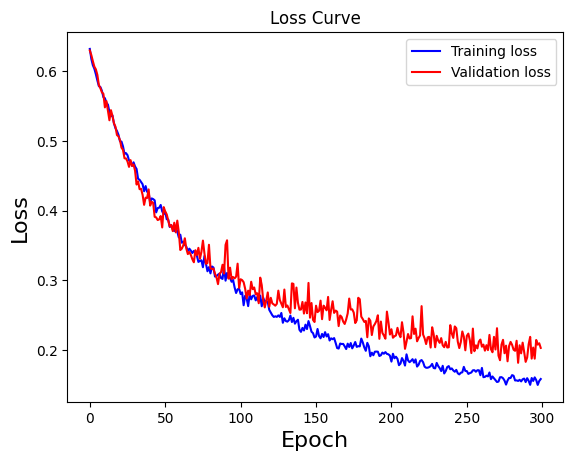

A Jupyter Widget

1/300 lr=0.00100 - loss:0.630, acc:17.835, val_loss:0.635, val_acc:21.250
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:0.618, acc:22.485, val_loss:0.628, val_acc:23.750
Best loss:0.635, Best accuracy:21.250, Best F1-score:0.163
3/300 lr=0.00100 - loss:0.608, acc:23.095, val_loss:0.620, val_acc:27.500
Best loss:0.628, Best accuracy:23.750, Best F1-score:0.178
4/300 lr=0.00100 - loss:0.604, acc:24.390, val_loss:0.612, val_acc:28.750
Best loss:0.620, Best accuracy:27.500, Best F1-score:0.215
5/300 lr=0.00100 - loss:0.596, acc:27.210, val_loss:0.605, val_acc:28.750
Best loss:0.612, Best accuracy:28.750, Best F1-score:0.218
6/300 lr=0.00100 - loss:0.588, acc:28.506, val_loss:0.593, val_acc:31.250
Best loss:0.612, Best accuracy:28.750, Best F1-score:0.218
7/300 lr=0.00100 - loss:0.581, acc:29.573, val_loss:0.588, val_acc:30.625
Best loss:0.593, Best accuracy:31.250, Best F1-score:0.256
8/300 lr=0.00100 - loss:0.574, acc:30.716, val_loss:0.585, val

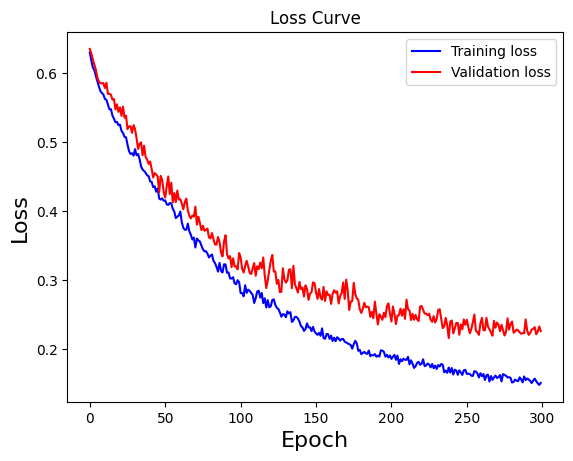

A Jupyter Widget

1/300 lr=0.00100 - loss:0.633, acc:13.872, val_loss:0.637, val_acc:16.875
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:0.620, acc:21.265, val_loss:0.629, val_acc:20.000
Best loss:0.637, Best accuracy:16.875, Best F1-score:0.115
3/300 lr=0.00100 - loss:0.613, acc:23.704, val_loss:0.612, val_acc:26.875
Best loss:0.629, Best accuracy:20.000, Best F1-score:0.158
4/300 lr=0.00100 - loss:0.605, acc:24.848, val_loss:0.602, val_acc:29.375
Best loss:0.612, Best accuracy:26.875, Best F1-score:0.205
5/300 lr=0.00100 - loss:0.595, acc:27.515, val_loss:0.589, val_acc:31.250
Best loss:0.602, Best accuracy:29.375, Best F1-score:0.236
6/300 lr=0.00100 - loss:0.588, acc:29.573, val_loss:0.581, val_acc:30.625
Best loss:0.589, Best accuracy:31.250, Best F1-score:0.256
7/300 lr=0.00100 - loss:0.579, acc:31.936, val_loss:0.569, val_acc:35.625
Best loss:0.589, Best accuracy:31.250, Best F1-score:0.256
8/300 lr=0.00100 - loss:0.576, acc:32.317, val_loss:0.576, val

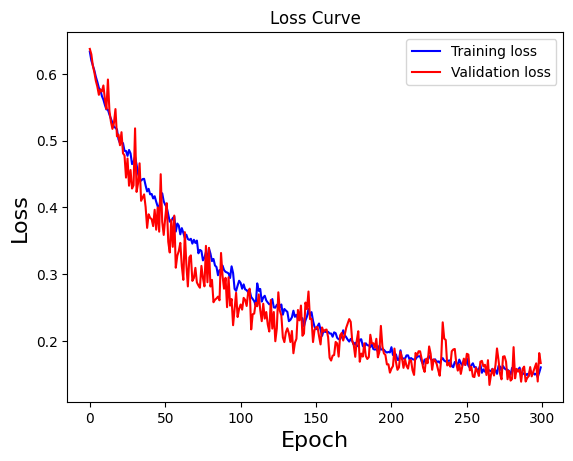

A Jupyter Widget

1/300 lr=0.00100 - loss:0.630, acc:16.997, val_loss:0.626, val_acc:21.250
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:0.620, acc:21.189, val_loss:0.616, val_acc:24.375
Best loss:0.626, Best accuracy:21.250, Best F1-score:0.155
3/300 lr=0.00100 - loss:0.611, acc:23.780, val_loss:0.601, val_acc:25.625
Best loss:0.616, Best accuracy:24.375, Best F1-score:0.180
4/300 lr=0.00100 - loss:0.605, acc:25.915, val_loss:0.587, val_acc:30.000
Best loss:0.601, Best accuracy:25.625, Best F1-score:0.186
5/300 lr=0.00100 - loss:0.597, acc:28.811, val_loss:0.576, val_acc:31.875
Best loss:0.587, Best accuracy:30.000, Best F1-score:0.240
6/300 lr=0.00100 - loss:0.594, acc:27.744, val_loss:0.567, val_acc:36.875
Best loss:0.576, Best accuracy:31.875, Best F1-score:0.246
7/300 lr=0.00100 - loss:0.589, acc:29.802, val_loss:0.562, val_acc:33.750
Best loss:0.567, Best accuracy:36.875, Best F1-score:0.321
8/300 lr=0.00100 - loss:0.585, acc:30.259, val_loss:0.550, val

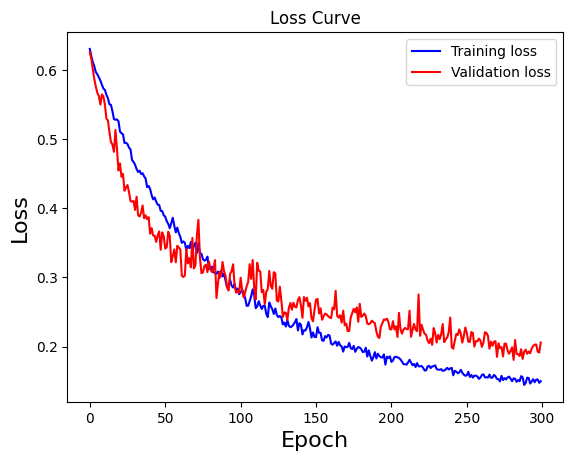

A Jupyter Widget

1/300 lr=0.00100 - loss:0.631, acc:15.320, val_loss:0.630, val_acc:21.875
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:0.616, acc:22.409, val_loss:0.618, val_acc:22.500
Best loss:0.630, Best accuracy:21.875, Best F1-score:0.153
3/300 lr=0.00100 - loss:0.606, acc:26.524, val_loss:0.607, val_acc:30.625
Best loss:0.618, Best accuracy:22.500, Best F1-score:0.169
4/300 lr=0.00100 - loss:0.597, acc:26.220, val_loss:0.600, val_acc:31.250
Best loss:0.607, Best accuracy:30.625, Best F1-score:0.232
5/300 lr=0.00100 - loss:0.592, acc:28.887, val_loss:0.595, val_acc:28.125
Best loss:0.600, Best accuracy:31.250, Best F1-score:0.251
6/300 lr=0.00100 - loss:0.584, acc:28.506, val_loss:0.578, val_acc:33.125
Best loss:0.600, Best accuracy:31.250, Best F1-score:0.251
7/300 lr=0.00100 - loss:0.580, acc:32.317, val_loss:0.568, val_acc:33.750
Best loss:0.578, Best accuracy:33.125, Best F1-score:0.255
8/300 lr=0.00100 - loss:0.572, acc:31.631, val_loss:0.555, val

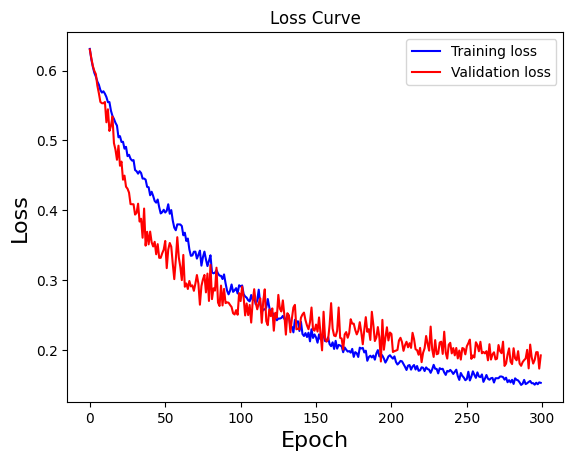

A Jupyter Widget

1/300 lr=0.00100 - loss:0.631, acc:17.454, val_loss:0.633, val_acc:16.875
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:0.618, acc:22.713, val_loss:0.618, val_acc:20.625
Best loss:0.633, Best accuracy:16.875, Best F1-score:0.083
3/300 lr=0.00100 - loss:0.608, acc:25.686, val_loss:0.610, val_acc:23.125
Best loss:0.618, Best accuracy:20.625, Best F1-score:0.157
4/300 lr=0.00100 - loss:0.597, acc:26.601, val_loss:0.606, val_acc:23.125
Best loss:0.610, Best accuracy:23.125, Best F1-score:0.165
5/300 lr=0.00100 - loss:0.589, acc:30.030, val_loss:0.598, val_acc:26.875
Best loss:0.610, Best accuracy:23.125, Best F1-score:0.165
6/300 lr=0.00100 - loss:0.582, acc:29.802, val_loss:0.586, val_acc:29.375
Best loss:0.598, Best accuracy:26.875, Best F1-score:0.203
7/300 lr=0.00100 - loss:0.574, acc:32.546, val_loss:0.586, val_acc:27.500
Best loss:0.586, Best accuracy:29.375, Best F1-score:0.239
8/300 lr=0.00100 - loss:0.573, acc:31.326, val_loss:0.567, val

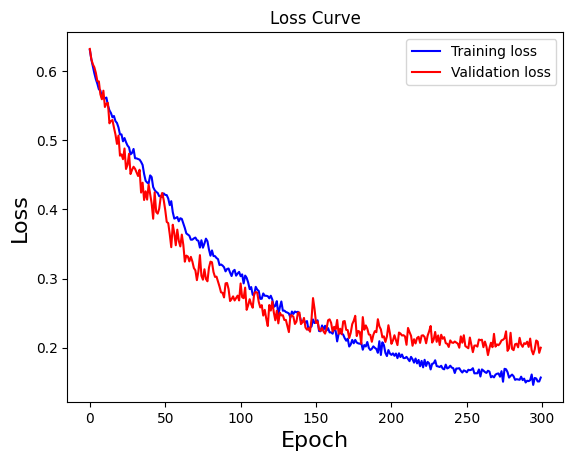

A Jupyter Widget

1/300 lr=0.00100 - loss:0.633, acc:16.997, val_loss:0.632, val_acc:31.875
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:0.620, acc:23.399, val_loss:0.618, val_acc:29.375
Best loss:0.632, Best accuracy:31.875, Best F1-score:0.279
3/300 lr=0.00100 - loss:0.609, acc:25.762, val_loss:0.607, val_acc:26.250
Best loss:0.632, Best accuracy:31.875, Best F1-score:0.279
4/300 lr=0.00100 - loss:0.601, acc:27.134, val_loss:0.594, val_acc:29.375
Best loss:0.632, Best accuracy:31.875, Best F1-score:0.279
5/300 lr=0.00100 - loss:0.591, acc:30.107, val_loss:0.595, val_acc:29.375
Best loss:0.632, Best accuracy:31.875, Best F1-score:0.279
6/300 lr=0.00100 - loss:0.579, acc:32.698, val_loss:0.566, val_acc:35.000
Best loss:0.632, Best accuracy:31.875, Best F1-score:0.279
7/300 lr=0.00100 - loss:0.575, acc:33.537, val_loss:0.556, val_acc:39.375
Best loss:0.566, Best accuracy:35.000, Best F1-score:0.295
8/300 lr=0.00100 - loss:0.574, acc:32.393, val_loss:0.552, val

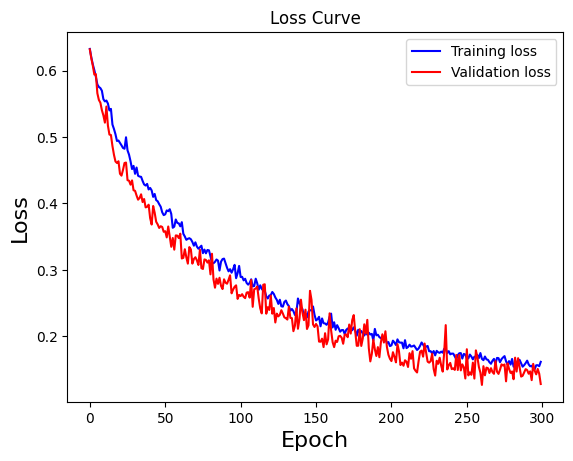

A Jupyter Widget

1/300 lr=0.00100 - loss:0.628, acc:18.826, val_loss:0.616, val_acc:21.250
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:0.614, acc:23.780, val_loss:0.606, val_acc:25.625
Best loss:0.616, Best accuracy:21.250, Best F1-score:0.146
3/300 lr=0.00100 - loss:0.605, acc:25.457, val_loss:0.603, val_acc:24.375
Best loss:0.606, Best accuracy:25.625, Best F1-score:0.191
4/300 lr=0.00100 - loss:0.599, acc:27.896, val_loss:0.591, val_acc:28.750
Best loss:0.606, Best accuracy:25.625, Best F1-score:0.191
5/300 lr=0.00100 - loss:0.586, acc:30.259, val_loss:0.578, val_acc:30.625
Best loss:0.591, Best accuracy:28.750, Best F1-score:0.214
6/300 lr=0.00100 - loss:0.584, acc:29.878, val_loss:0.571, val_acc:34.375
Best loss:0.578, Best accuracy:30.625, Best F1-score:0.233
7/300 lr=0.00100 - loss:0.583, acc:29.040, val_loss:0.567, val_acc:34.375
Best loss:0.571, Best accuracy:34.375, Best F1-score:0.282
8/300 lr=0.00100 - loss:0.584, acc:28.887, val_loss:0.563, val

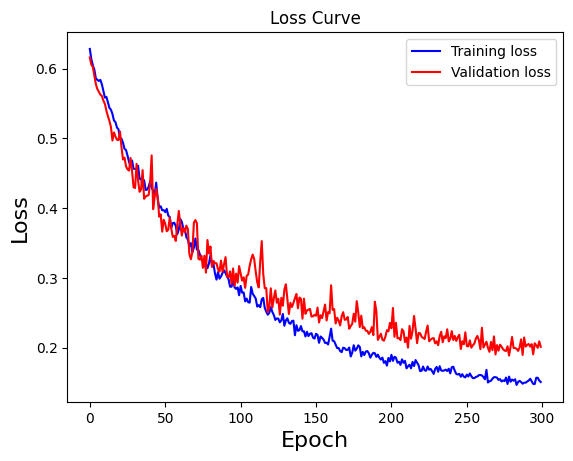

A Jupyter Widget

1/300 lr=0.00100 - loss:0.631, acc:17.226, val_loss:0.628, val_acc:18.125
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:0.616, acc:23.095, val_loss:0.616, val_acc:22.500
Best loss:0.628, Best accuracy:18.125, Best F1-score:0.103
3/300 lr=0.00100 - loss:0.607, acc:24.924, val_loss:0.603, val_acc:26.250
Best loss:0.616, Best accuracy:22.500, Best F1-score:0.156
4/300 lr=0.00100 - loss:0.598, acc:27.591, val_loss:0.599, val_acc:28.125
Best loss:0.603, Best accuracy:26.250, Best F1-score:0.205
5/300 lr=0.00100 - loss:0.592, acc:28.049, val_loss:0.588, val_acc:30.000
Best loss:0.599, Best accuracy:28.125, Best F1-score:0.215
6/300 lr=0.00100 - loss:0.586, acc:27.896, val_loss:0.580, val_acc:28.750
Best loss:0.588, Best accuracy:30.000, Best F1-score:0.218
7/300 lr=0.00100 - loss:0.576, acc:31.326, val_loss:0.578, val_acc:30.000
Best loss:0.588, Best accuracy:30.000, Best F1-score:0.218
8/300 lr=0.00100 - loss:0.574, acc:31.326, val_loss:0.574, val

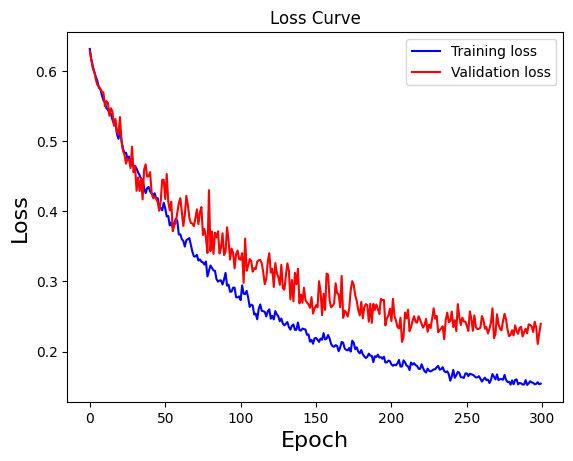

A Jupyter Widget

1/300 lr=0.00100 - loss:0.632, acc:14.558, val_loss:0.626, val_acc:16.875
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/300 lr=0.00100 - loss:0.619, acc:21.265, val_loss:0.612, val_acc:21.875
Best loss:0.626, Best accuracy:16.875, Best F1-score:0.105
3/300 lr=0.00100 - loss:0.608, acc:24.848, val_loss:0.603, val_acc:29.375
Best loss:0.612, Best accuracy:21.875, Best F1-score:0.145
4/300 lr=0.00100 - loss:0.601, acc:26.448, val_loss:0.588, val_acc:31.875
Best loss:0.603, Best accuracy:29.375, Best F1-score:0.227
5/300 lr=0.00100 - loss:0.593, acc:27.973, val_loss:0.572, val_acc:35.000
Best loss:0.588, Best accuracy:31.875, Best F1-score:0.248
6/300 lr=0.00100 - loss:0.586, acc:28.582, val_loss:0.570, val_acc:34.375
Best loss:0.572, Best accuracy:35.000, Best F1-score:0.291
7/300 lr=0.00100 - loss:0.576, acc:32.317, val_loss:0.567, val_acc:35.625
Best loss:0.572, Best accuracy:35.000, Best F1-score:0.291
8/300 lr=0.00100 - loss:0.576, acc:30.030, val_loss:0.560, val

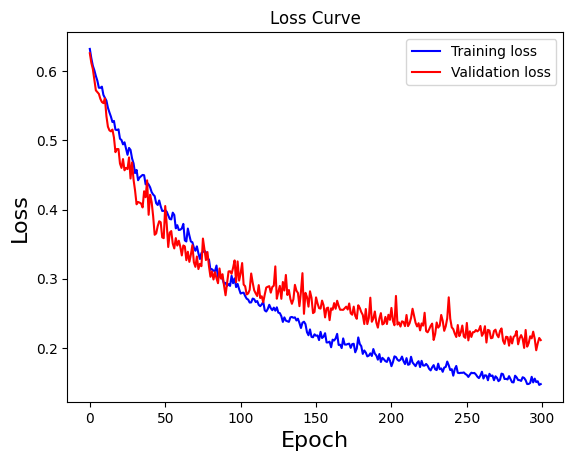

In [20]:
import tensorflow_addons as tfa
from keras.models import load_model

emotions_groundtruth_list = np.array([])
predicted_emotions_list = np.array([])

fold_acc = []

kfold = KFold(n_splits=k, shuffle=True, random_state=98)

for i, (train, test) in tqdm(enumerate(kfold.split(x, y)), desc=f'Training {k}-Fold.....'):
    # if i < 8:
    #     continue
    
    now_time = datetime.now().strftime("%m-%d-%H%M%S")
    
    save_path = f'Models/{DATA_PATH}'
    os.makedirs(save_path, exist_ok=True)
    h5_path = f'{save_path}/{model_name}_{i}-fold_.h5'
    
    x_train, y_train = x[train], y[train]
    y_train = smooth_labels(y[train], 0.1)
    
    x_test, y_test = x[test], y[test]
    
    x_train = tf.expand_dims(x_train, axis=-1)
    x_test = tf.expand_dims(x_test, axis=-1)
    
    shape = x_train.shape[1:]
    
    optimizer = Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
    
    model = Model(len(CLASS_LABELS))
    
    best_test_loss = 0x3f3f3f
    best_test_acc = -1
    best_test_f1 = -1
    
    epoch_losses = []
    valid_losses = []
    
    batch_train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(2022).batch(BATCH)
    batch_test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH)
    for epoch in tqdm(range(EPOCHS), desc=f'Fold-{i+1}'):

        train_loss, train_acc = [], []
        for features, labels in batch_train:
            loss, acc = train_step(model, optimizer, features, labels)
            train_loss.append(loss)
            train_acc.append(acc)
            
        test_loss, test_acc, f1s = [], [], []
        for features, labels in batch_test:
            loss, acc, pred = test_step(model, features, labels)
            test_loss.append(loss)
            test_acc.append(acc)
            
            f1_metric = tfa.metrics.F1Score(num_classes=len(CLASS_LABELS), average='weighted')
            f1_metric.update_state(labels, pred)
            f1 = f1_metric.result().numpy()
            f1s.append(f1)
            
        
        epoch_loss = sum(train_loss)/len(train_loss)
        epoch_acc = sum(train_acc)/len(train_acc)
        val_loss = sum(test_loss)/len(test_loss)
        val_acc = sum(test_acc)/len(test_acc)
        f1_score = sum(f1s)/len(f1s)
        
        epoch_losses.append(epoch_loss)
        valid_losses.append(val_loss)
        
        cur_lr = K.eval(optimizer.lr)
        print(f'{epoch+1}/{EPOCHS} lr={cur_lr:.5f} - loss:{epoch_loss:.3f}, acc:{epoch_acc:.3f}, val_loss:{val_loss:.3f}, val_acc:{val_acc:.3f}')
        print(f'Best loss:{best_test_loss:.3f}, Best accuracy:{best_test_acc:.3f}, Best F1-score:{best_test_f1:.3f}')
        
        set_lr = scheduler(epoch, K.eval(optimizer.lr))
        K.set_value(optimizer.learning_rate, set_lr)
        
        if best_test_acc < val_acc:
            best_test_acc = val_acc
            best_test_loss = val_loss
            best_test_f1 = f1_score
            model.save_weights(h5_path)
            
            
    model = Model(len(CLASS_LABELS))
    model.build(input_shape=x_train.shape)
    model.load_weights(h5_path)
    best_pred = model(x_test, training=False)
    emotions_groundtruth_list = np.append(emotions_groundtruth_list, np.argmax(y_test, axis=1))
    predicted_emotions_list = np.append(predicted_emotions_list, np.argmax(best_pred, axis=1))
    
    
    print(f'[*] Done - acc:{best_test_acc:.3f}')
    
    plt.title('Loss Curve')
    plt.ylabel('Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.plot(epoch_losses[:],'b')
    plt.plot(valid_losses[:],'r')
    plt.legend(['Training loss','Validation loss'])
    plt.show()
    
    fold_acc.append(best_test_acc)
    

In [21]:
end()

Webhook status code 404: {"message": "Unknown Webhook", "code": 10015}


In [22]:
print(f'max:{max(fold_acc)}, min:{min(fold_acc)}, average:{sum(fold_acc)/len(fold_acc)}')

max:88.125, min:75.625, average:81.3125


In [23]:
import warnings
warnings.filterwarnings('always')

Report = classification_report(emotions_groundtruth_list, predicted_emotions_list)

os.makedirs(f'Results/{DATA_PATH}', exist_ok=True)
report_path = f'Results/{DATA_PATH}/{model_name}_{feature_name}_{k}-fold_nomalize.txt'

with open(report_path, "w") as f:
    f.write(Report)

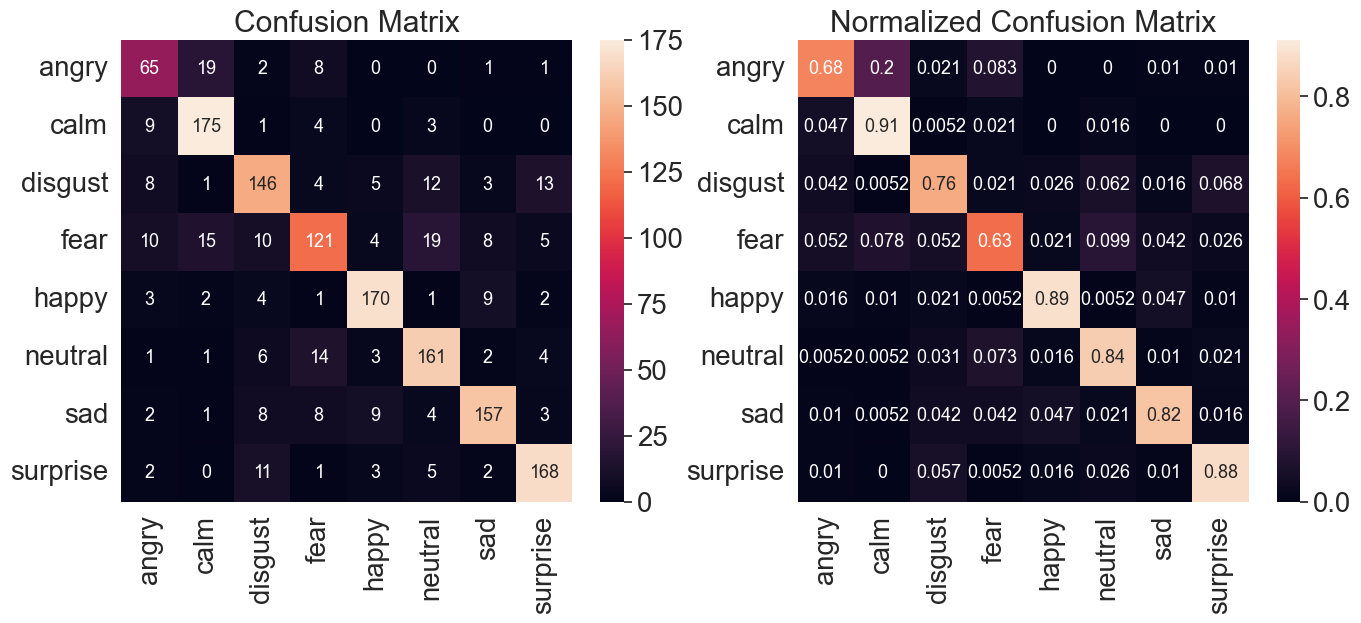

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

emotion_names = CLASS_LABELS


# build confusion matrix and normalized confusion matrix
conf_matrix = confusion_matrix(emotions_groundtruth_list, predicted_emotions_list)
conf_matrix_norm = confusion_matrix(emotions_groundtruth_list, predicted_emotions_list,normalize='true')

# make a confusion matrix with labels using a DataFrame
confmatrix_df = pd.DataFrame(conf_matrix, index=emotion_names, columns=emotion_names)
confmatrix_df_norm = pd.DataFrame(conf_matrix_norm, index=emotion_names, columns=emotion_names)

# plot confusion matrices
plt.figure(figsize=(16,6))
sn.set(font_scale=1.8) # emotion label and title size
plt.subplot(1,2,1)
plt.title('Confusion Matrix')
sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 13}, fmt='g') #annot_kws is value font
plt.subplot(1,2,2)
plt.title('Normalized Confusion Matrix')
sn.heatmap(confmatrix_df_norm, annot=True, annot_kws={"size": 13}) #annot_kws is value font
plt.savefig(f'Results/{DATA_PATH}/{model_name}_{feature_name}_{k}-fold_confmatrix.pdf')
plt.show()

In [25]:
get_metric_calc(conf_matrix)

WAR(Weighted Average Recall)   : 79.95%
UAR(Unweighted Average Recall) : 79.95%
